In [1]:
import tensorflow 
from tensorflow.keras.layers import Input, Dense, Conv2D, GlobalMaxPooling2D,MaxPooling2D, UpSampling2D,Flatten,Reshape,BatchNormalization,Dropout,LeakyReLU,ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.activations import selu
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=5)
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from matplotlib import  pylab as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend
#backend.set_image_data_format('channels_first')
print('Done!')

Done!


In [2]:
# A function for plotting performance
# updatable plot
# a minimal example (sort of)
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="train")
        plt.plot(self.x, self.val_losses, label="validation",linestyle='--')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


In [3]:
## Getting MNIST data 


##Defining Input and target and normalizing the input


from tensorflow.keras.datasets import mnist

(inp_tr, tar_tr), (inp_va, tar_va) = mnist.load_data()

inp_tr = np.reshape(inp_tr,(-1,784))
inp_va = np.reshape(inp_va,(-1,784))

c_noise=4

noise_tr=np.random.rand(60000,784)*c_noise
noise_va=np.random.rand(10000,784)*c_noise

inp_tr= inp_tr/255.
inp_va= inp_va/255.

inp_tr_noise=(inp_tr+noise_tr)/(1+c_noise)
inp_va_noise=(inp_va+noise_va)/(1+c_noise)

print(np.shape(inp_tr_noise),np.shape(inp_va_noise))

(60000, 784) (10000, 784)


<Figure size 640x480 with 0 Axes>

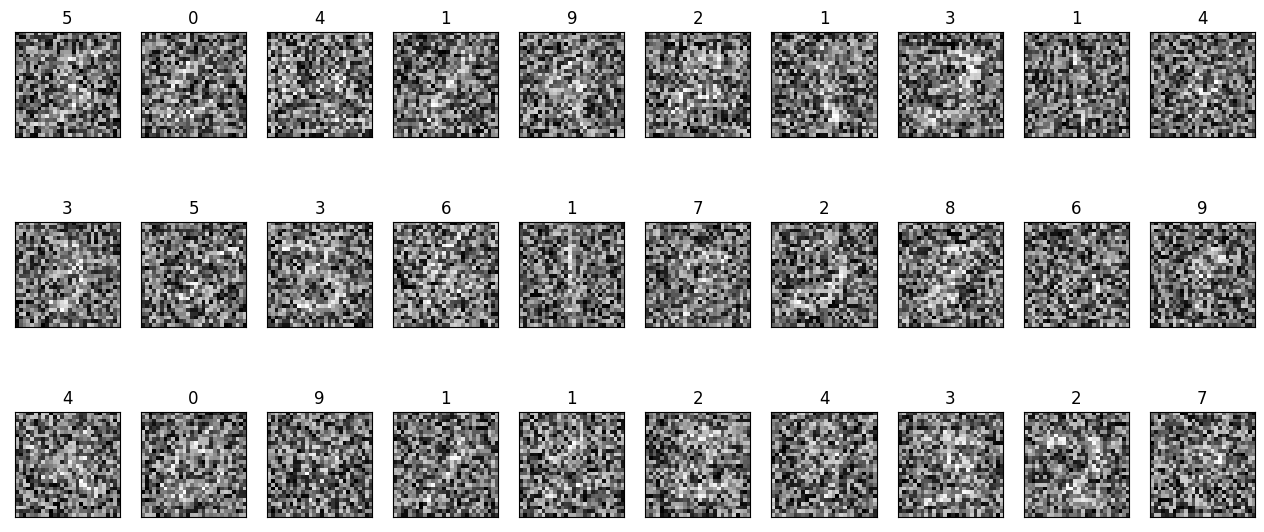

In [4]:
# presenting some digits

n1=0
n2=30
plt.gray()
fig = plt.figure( figsize=(16,7) )
for k1 in range(n1,n2):
    ax = fig.add_subplot(3,10,k1+1, title=str(int(tar_tr[k1])))
    ax.matshow(inp_tr_noise[k1].reshape((28,28)).astype(float))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [31]:
en_input = tensorflow.keras.Input(shape=(784,), name='Layer_input')
encoded = layers.Dense(512, activation='relu', name='Layer_1')(en_input)
encoded = layers.Dense(256, activation='relu', name='Layer_2')(encoded)

z = layers.Dense(10, activation='relu', name='Layer_3_latent')(encoded)

decoded = layers.Dense(256, activation='relu', name='Layer_4')(z)
decoded = layers.Dense(512, activation='relu', name='Layer_5')(decoded)
de_output = layers.Dense(784, activation='sigmoid', name='Layer_output')(decoded)

In [32]:
autoencoder = tensorflow.keras.Model(en_input, de_output)
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_input (InputLayer)    [(None, 784)]             0         
                                                                 
 Layer_1 (Dense)             (None, 512)               401920    
                                                                 
 Layer_2 (Dense)             (None, 256)               131328    
                                                                 
 Layer_3_latent (Dense)      (None, 10)                2570      
                                                                 
 Layer_4 (Dense)             (None, 256)               2816      
                                                                 
 Layer_5 (Dense)             (None, 512)               131584    
                                                                 
 Layer_output (Dense)        (None, 784)               4021

In [33]:
Encoder = tensorflow.keras.Model(en_input, z)
Encoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_input (InputLayer)    [(None, 784)]             0         
                                                                 
 Layer_1 (Dense)             (None, 512)               401920    
                                                                 
 Layer_2 (Dense)             (None, 256)               131328    
                                                                 
 Layer_3_latent (Dense)      (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [34]:
Decoder = tensorflow.keras.Model(z,de_output )
Decoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 Layer_4 (Dense)             (None, 256)               2816      
                                                                 
 Layer_5 (Dense)             (None, 512)               131584    
                                                                 
 Layer_output (Dense)        (None, 784)               402192    
                                                                 
Total params: 536,592
Trainable params: 536,592
Non-trainable params: 0
_________________________________________________________________


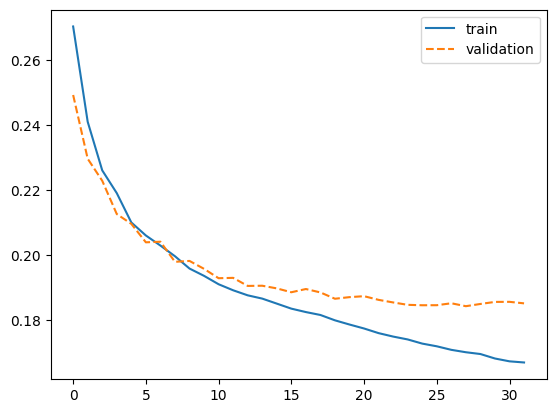

235/235 [==============================] - 1s 4ms/step - loss: 0.1670 - val_loss: 0.1852


In [35]:

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

autoencoder.fit(inp_tr_noise, inp_tr,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(inp_va_noise, inp_va),callbacks=[plot_losses,early_stopping])

In [36]:
inp_va_pred=autoencoder.predict(inp_va_noise)

313/313 [==============================] - 0s 1ms/step


<Figure size 640x480 with 0 Axes>

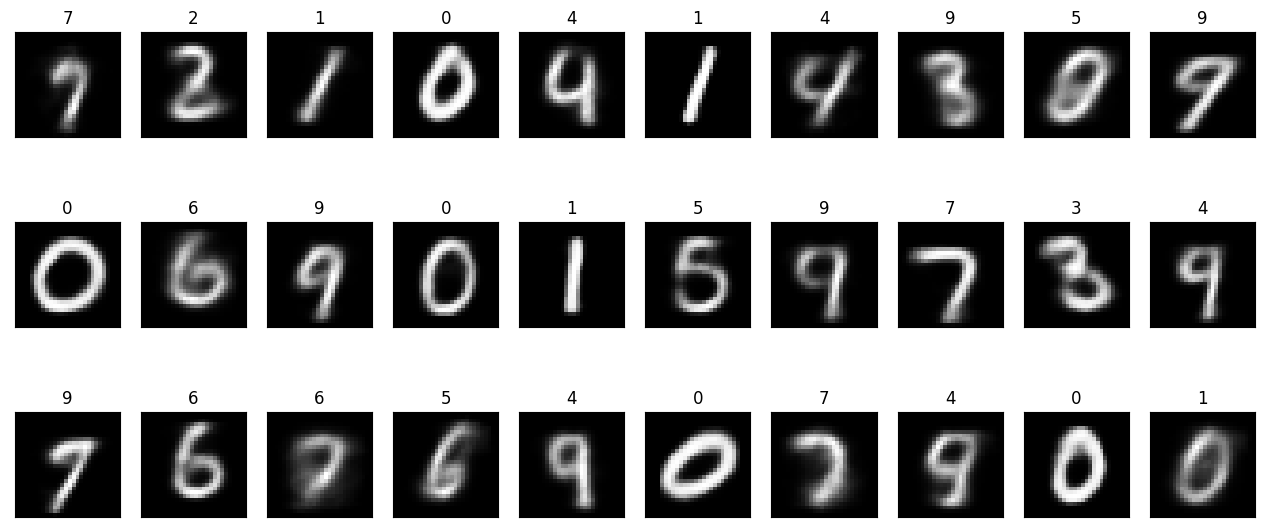

In [37]:
# presenting some digits

n1=0
n2=30
plt.gray()
fig = plt.figure( figsize=(16,7) )
for k1 in range(n1,n2):
    ax = fig.add_subplot(3,10,k1+1, title=str(int(tar_va[k1])))
    ax.matshow(inp_va_pred[k1].reshape(28,28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [38]:
# Get the latent data
z_inp_tr = Encoder.predict(inp_tr)

np.shape(z_inp_tr)

1875/1875 [==============================] - 2s 798us/step


(60000, 10)

In [39]:
# Create a display function: displaying two data sets together

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

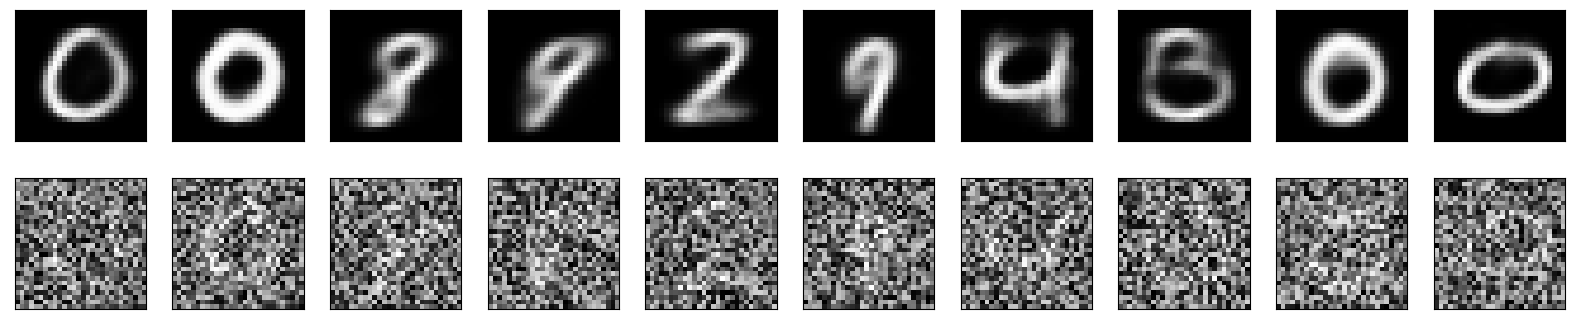

In [40]:
# use the display function
display(inp_va_pred, inp_va_noise)

# Generetive models
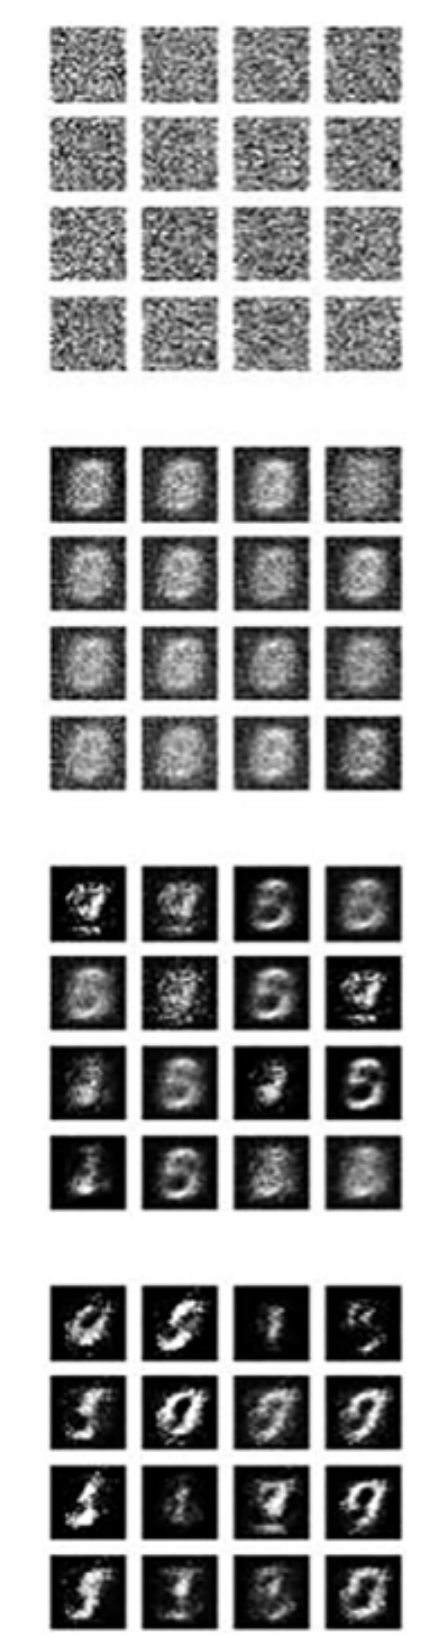